In [1]:
import numpy as np
from scipy.optimize import linprog, OptimizeWarning
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import warnings
import os

FILEPATH = os.getcwd()
SEED = 22460181
SAVE = True

# Parte 3. Introducción al Transporte Óptimo

Considere que el transporte óptimo entre dos distribuciones discretas $\alpha=\sum_{i=1}^na_i\delta_{x_i}$ y $\beta=\sum_{j=1}^mb_j\delta_{y_j}$ está dado por

$$P^\ast=\text{argmin}_{P\in U(a,b)}\sum_{i,j}P_{ij}C_{ij}$$

donde $U(a,b)=\{P\in\mathbb{R}^{n\times m}_+~:~\forall i,\sum_j P_{ij}=a_i,~\forall j,\sum_iP_{ij}=b_j\}$ y $C_{ij}=\|x_i-y_j\|^2$.

a) Usando algún solver de programación lineal, implemente un método que resuelva el problema.

In [2]:
def block_i(i, n, m):
    """
    Retorna una matriz de n x m con
    ceros en todas partes y solo 1's
    en la fila (i+1)
    """
    temp = np.zeros((n,m))
    temp[i,:] = 1
    return temp

def solver(x, y, a, b):
    """
    Parameters:
    -----------
    - x: np.ndarray
        n vectores de dimensión d
    - y: np.ndarray
        m vectores de dimensión d
    - a: np.ndarray
        n pesos, para cada vector en x
    - b: np.ndarray
        m pesos, para cada vector en y
    """

    (n, m) = (x.shape[0], y.shape[0])
    
    # Obtenemos las distancias
    c = distance_matrix(x, y) ** 2

    # Construimos la matriz de restricciones de igualdad
    
    # Restricciones sum_j P_{ij} = a_i
    Z_up = np.block([block_i(i, n, m) for i in range(n)])
    
    # Restricciones sum_i P_{ij} = b_j
    Z_down = np.block([np.eye(m) for i in range(n)])
    
    Z = np.vstack([Z_up, Z_down])
    w = np.concatenate([a, b])
    
    # Condición de positividad
    bounds = [(0, None)]
    
    # Resolvemos
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=OptimizeWarning)
        
        sol = linprog(c=c.reshape(-1), A_eq=Z, b_eq=w, bounds=bounds)
    
    # Entregamos la solucion y la matriz c
    return sol, c

Sean $X_1\sim\mathcal N(\mu_1,\Sigma_1)$ y $X_2\sim\mathcal N(\mu_2,\Sigma_2)$ distribuciones gaussianas en $\mathbb R^d$. El transporte óptimo está dado por la siguiente expresión cerrada:

$$T(x)=\mu_2+A(x-\mu_1),\qquad A=\Sigma_1^{-1/2}\left(\Sigma_1^{1/2}\Sigma_2\Sigma_1^{1/2}\right)^{1/2}\Sigma_1^{-1/2}.$$

con lo cual la distancia de Wasserstein es:

$$W_2\left(\mathcal N(\mu_1,\Sigma_1),\mathcal N(\mu_2,\Sigma_2)\right) = \|\mu_1-\mu_2\|_2^2+\text{Tr}\left(\Sigma_1+\Sigma_2-2\left(\Sigma_1^{1/2}\Sigma_2\Sigma_1^{1/2}\right)^{1/2}\right)$$

b) Comente la intuición detrás de la expresión cerrada del transporte óptimo entre dos gaussianas.

**Respuesta:** Para el caso $d=1$ tenemos que $\Sigma_1=\sigma_1^2$ y $\Sigma_2=\sigma_2^2$ corresponden a las varianzas y $A=\sigma_1^{-1}\left(\sigma_1\sigma_2^2\sigma_1\right)^{1/2}\sigma_1^{-1}=\frac{\sigma_2}{\sigma_1}$, por lo cual el transporte óptimo viene dado por 

$$T(x)=\mu_2+\frac{\sigma_2}{\sigma_1}(x-\mu_1).$$

Notemos que el transporte óptimo se puede ver como tres transformaciones que llevan $\mathcal N(\mu_1,\Sigma_1)$ a $\mathcal N(\mu_2,\Sigma_2)$. Sea $x\in\mathcal N(\mu_1,\sigma_1^2)$, entonces $x-\mu_1\in\mathcal N(0,\sigma_1)$, es decir, llevamos $x$ al origen, luego al multiplicar por $A$ tenemos $A(x-\mu_1)\in\mathcal N(0,\sigma_2^2)$, es decir, achicamos por $\sigma_1$ y amplificamos por $\sigma_2$, y por último, trasladamos a la segunda distribución de modo que $\mu_2+A(x-\mu_1)\in\mathcal N(\mu_2,\sigma_2^2)$.

De manera general (para $d>1$) la intución es la misma, primero trasladamos los datos al origen, luego en el origen deformamos la primera distribución hasta obtener la forma de la segunda distribución. Por último, una vez obtenemos la forma correcta, centramos en la media de la distribución objetivo.

c) Samplee de las distribuciones para parámetros de su elección y resuelva el método anterior para $d=1$. Compare además con el valor teórico.

In [3]:
def Wasserstein_distance(mu, sigma):
    """
    Calcula la distancia de Wasserstein
    entre dos distribuciones normales.
    
    Parameters:
    -----------
    - mu: np.ndarray(2)
        media de las distribuciones normales
    - sigma: np.ndarray
        varianza de las distribuciones normales
    """
    
    mu_1, mu_2 = mu
    sigma_1, sigma_2 = sigma
    
    return (mu_1 - mu_2) ** 2 + (sigma_1 + sigma_2 - 2*np.sqrt(np.sqrt(sigma_1)*sigma_2*np.sqrt(sigma_1)))

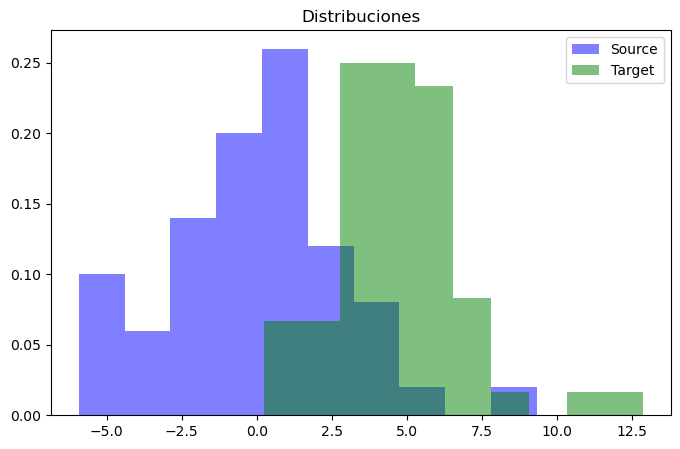

In [4]:
np.random.seed(SEED)

# Definimos hiperparámetros
(mu_1, mu_2) = (0, 5)
(sigma_1, sigma_2) = (3, 2)

# Generamos datos de las distribuciones normales
(d, n, m) = (1, 50, 60)
x = np.random.normal(loc=mu_1, scale=sigma_1, size=n).reshape(-1, 1)
y = np.random.normal(loc=mu_2, scale=sigma_2, size=m).reshape(-1, 1)

# Generamos pesos uniformes
a = np.ones(n) / n
b = np.ones(m) / m

# Graficamos las distribuciones
plt.figure(figsize=(8,5))
plt.title('Distribuciones')

plt.hist(x, weights=a, alpha=0.5, label='Source', color='blue')
plt.hist(y, weights=b, alpha=0.5, label='Target', color='green')

plt.legend(loc='upper right')

if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\distributions-1d.pdf', bbox_inches='tight')
    
plt.show()

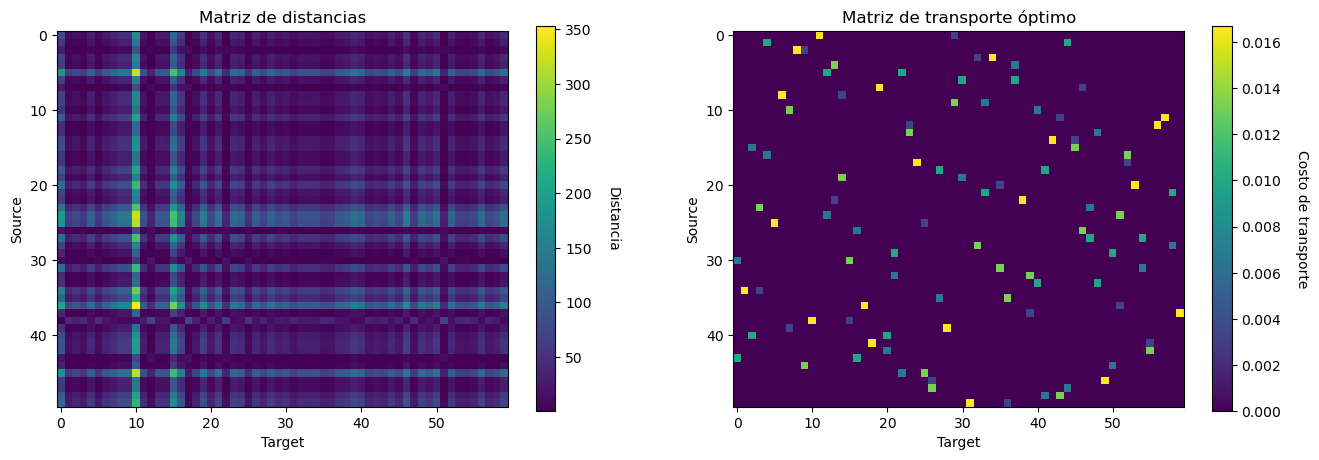

In [5]:
# Resolvemos
sol, c = solver(x, y, a, b)

# Graficamos
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

distance_img = ax1.imshow(c.reshape(n,m), cmap='viridis', interpolation='nearest')
colorbar = plt.colorbar(distance_img, ax=ax1)
colorbar.set_label('Distancia', rotation=270, labelpad=20)

sol_img = ax2.imshow(sol.x.reshape(n,m), cmap='viridis', interpolation='nearest')
colorbar = plt.colorbar(sol_img, ax=ax2)
colorbar.set_label('Costo de transporte', rotation=270, labelpad=20)

ax1.set_title('Matriz de distancias')
ax1.set_xlabel('Target')
ax1.set_ylabel('Source')

ax2.set_title('Matriz de transporte óptimo')
ax2.set_xlabel('Target')
ax2.set_ylabel('Source')

if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\ot-1d.pdf', bbox_inches='tight')

plt.show()

In [6]:
# Comparamos el valor teórico con el óptimo obtenido por el solver
W = Wasserstein_distance([mu_1, mu_2], [sigma_1, sigma_2])

print(f"Valor teórico: {W}")
print(f"Óptimo del solver: {sol.fun}")

Valor teórico: 25.101020514433642
Óptimo del solver: 22.885297604211594


d) Samplee y grafique dos gaussianas para el caso $d=2$. Use el método para calcular el transporte óptimo y grafique las asignaciones que induce.

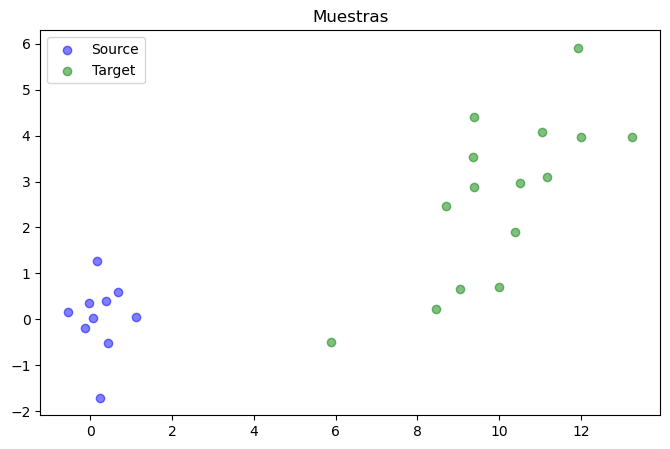

In [7]:
np.random.seed(SEED)

# Usaremos pocas muestras para tener gráficos más limpios
(n, m) = (10, 15)

# Definimos hiper-parámetros
mu_1, mu_2 = np.array([0, 0]), np.array([10, 3])
sigma_1, sigma_2 = np.array([[1, 0], [0, 1]]), np.array([[2, 1], [1, 2]])

# Sampleamos
x = np.random.multivariate_normal(mu_1, sigma_1, n)
y = np.random.multivariate_normal(mu_2, sigma_2, m)

# Definimos pesos uniformes
a = np.ones(n) / n
b = np.ones(m) / m

# Graficamos las muestras
plt.figure(figsize=(8,5))
plt.title('Muestras')

plt.scatter(x[:,0], x[:,1], alpha=0.5, label='Source', color='blue')
plt.scatter(y[:,0], y[:,1], alpha=0.5, label='Target', color='green')
plt.legend()

if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\samples-2d.pdf', bbox_inches='tight')

plt.show()

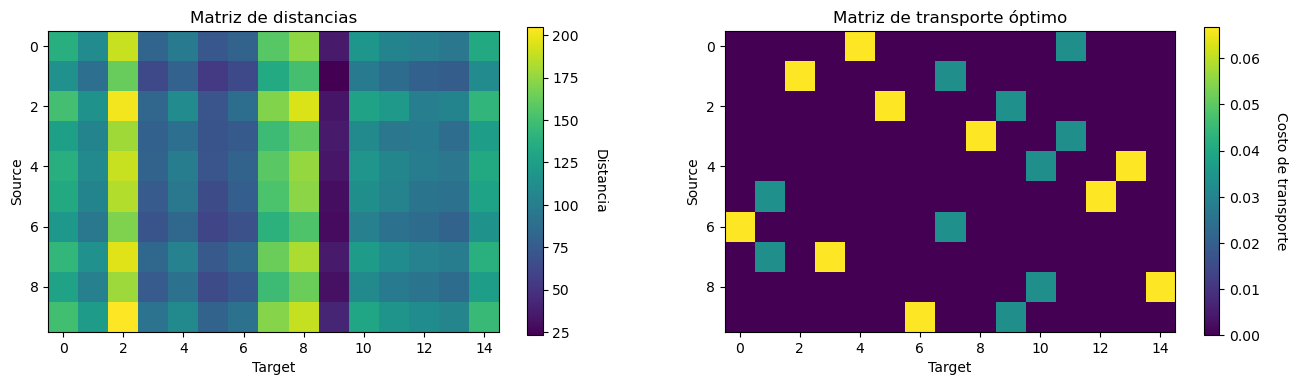

In [8]:
# Resolvemos
sol, c = solver(x, y, a, b)

# Graficamos
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

distance_img = ax1.imshow(c.reshape(n,m), cmap='viridis', interpolation='nearest')
colorbar = plt.colorbar(distance_img, ax=ax1)
colorbar.set_label('Distancia', rotation=270, labelpad=20)

sol_img = ax2.imshow(sol.x.reshape(n,m), cmap='viridis', interpolation='nearest')
colorbar = plt.colorbar(sol_img, ax=ax2)
colorbar.set_label('Costo de transporte', rotation=270, labelpad=20)

ax1.set_title('Matriz de distancias')
ax1.set_xlabel('Target')
ax1.set_ylabel('Source')

ax2.set_title('Matriz de transporte óptimo')
ax2.set_xlabel('Target')
ax2.set_ylabel('Source')

if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\ot-2d.pdf', bbox_inches='tight')

plt.show()

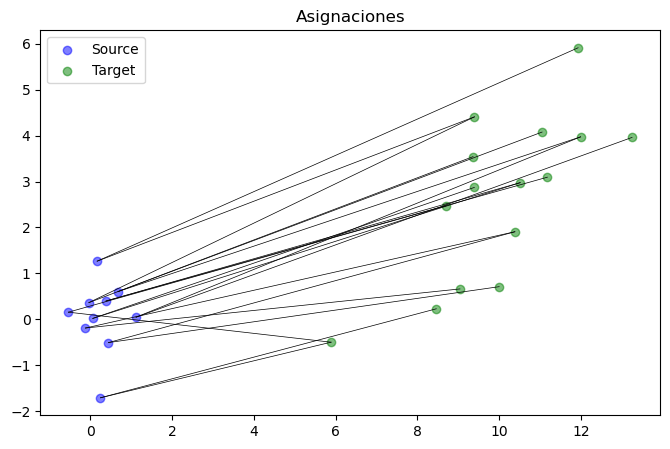

In [9]:
# Obtenemos las asignaciones 
asignaciones = sol.x.reshape(n, m).copy()

# Anulamos los despreciables
for i, row in enumerate(asignaciones):
    mask = row > 1e-5
    asignaciones[i] = mask*asignaciones[i]
    
# Obtenemos los índices no nulos
row_indices, col_indices = np.nonzero(asignaciones)
nonzero_indices = list(zip(row_indices, col_indices))

# Graficamos
plt.figure(figsize=(8,5))
plt.title('Asignaciones')

plt.scatter(x[:,0], x[:,1], alpha=0.5, label='Source', color='blue')
plt.scatter(y[:,0], y[:,1], alpha=0.5, label='Target', color='green')

for index in nonzero_indices:
    i, j = index
    plt.plot([x[i,0],y[j,0]], [x[i,1],y[j,1]], linewidth=0.5, color='black')
    
plt.legend()    

if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\asignations.pdf', bbox_inches='tight')

plt.show()

Para dos distribuciones $\alpha$ y $\beta$, y $t\in[0,1]$ podemos definir el baricentro de Wasserstein como:

$$\mu_t=\text{argmin}_{\mu}(1-t)W_2(\alpha,\mu)^2+tW_2(\beta,\mu)^2,$$
que puede entenderse como la generalización del baricentro euclideano para distribuciones. Una vez que tenemos acceso al transporte óptimo $P^\ast$, la interpolación en cuestión está dada por:

$$\mu_t=\sum_{i,j}P_{ij}^\ast\delta_{(1-t)x_i+ty_j}.$$

e) Para una cantidad adecuada de pasos $t_0=0<t_1<\cdots<t_k=1$, compute y grafique las distribuciones empíricas para el baricentro $\mu_{t_i},~i=1,\ldots,k$

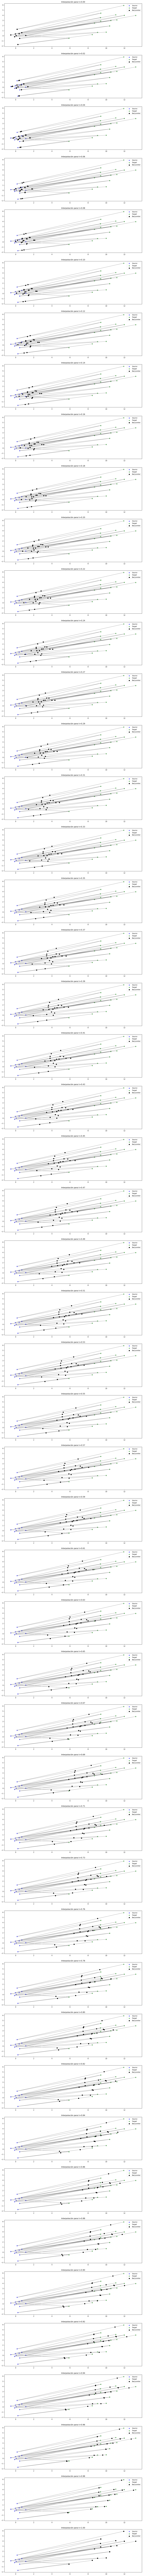

In [10]:
# Obtenemos una grilla para t
t = np.linspace(0, 1, 50)

fig, axes = plt.subplots(nrows=len(t), ncols=1, figsize=(16, 6*len(t)))

for k, ax in enumerate(axes.flatten()):
    ax.set_title(f"Interpolación para t={t[k]:.2f}")
    ax.scatter(x[:,0], x[:,1], alpha=0.5, label='Source', color='blue')
    ax.scatter(y[:,0], y[:,1], alpha=0.5, label='Target', color='green')
    
    if nonzero_indices:
        ax.scatter([], [], color='black', label='Barycenter')
    
    for index in nonzero_indices:
        i, j = index
        z = (1-t[k])*x[i]+t[k]*y[j]
        ax.plot([x[i,0],y[j,0]], [x[i,1],y[j,1]], linewidth=0.5, color='black')
        ax.scatter(z[0], z[1], color='black')
        
    ax.legend()
        
plt.show()

In [11]:
# Código para descargar los frames

# t = np.linspace(0, 1, 50)

# plt.figure(figsize=(16,6))

# for k, tk in enumerate(t):
#     plt.title(f"Interpolación para t={tk:.2f}")
#     plt.scatter(x[:,0], x[:,1], alpha=0.5, label='Source', color='blue')
#     plt.scatter(y[:,0], y[:,1], alpha=0.5, label='Target', color='green')
#     plt.scatter([], [], color='black', label='Barycenter')
#     label_added = True
    
#     for index in nonzero_indices:
#         i, j = index
#         z = (1-tk)*x[i]+tk*y[j]
#         plt.plot([x[i,0],y[j,0]], [x[i,1],y[j,1]], linewidth=0.5, color='black')
#         plt.scatter(z[0], z[1], color='black')
        
#     plt.legend()
    
#     plt.savefig(f'{FILEPATH}\\Imágenes\\barycenter_{tk:.2f}.jpg', bbox_inches='tight')
        
#     plt.clf()
    
# Generamos un gif
# path = "./Imágenes/"
# img_names = os.listdir(path)

# imagenes = np.array(list(map(lambda img: np.array(Image.open(path + img)), img_names)))

# imageio.mimsave(f'./barycenter.gif', imagenes)

![GIF](https://raw.githubusercontent.com/DanielMinaya1/MDS7203/main/Laboratorio_1/barycenter.gif)